In [1]:
import pandas as pd
import numpy as np
from Machine_Learning_Tools.plots import *
from Machine_Learning_Tools.Neural_Networks_Models import single_layer_perceptron,set_random_seed
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import tensorflow.keras as kr
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pickle
warnings.filterwarnings("ignore")
sns.set_theme(context='notebook',style='whitegrid',palette='dark',font_scale=1.0)
%matplotlib inline

In [2]:
X_train = pd.read_csv('datasets/X_train.csv')
y_train = pd.read_csv('datasets/y_train.csv')

X_test = pd.read_csv('datasets/X_test.csv')
y_test = pd.read_csv('datasets/test_label/y_test.csv')

df = X_train.merge(y_train)

In [3]:
X_train.head()

carID     brand      model  year transmission  mileage fuelType    tax  \
0  13207    hyundi   Santa Fe  2019    Semi-Auto     4223   Diesel  145.0   
1  17314  vauxhall        GTC  2015       Manual    47870   Diesel  125.0   
2  12342      audi        RS4  2019    Automatic     5151   Petrol  145.0   
3  13426        vw   Scirocco  2016    Automatic    20423   Diesel   30.0   
4  16004     skoda      Scala  2020    Semi-Auto     3569   Petrol  145.0   

    mpg  engineSize  
0  39.8         2.2  
1  60.1         2.0  
2  29.1         2.9  
3  57.6         2.0  
4  47.1         1.0

In [4]:
df = df.drop('carID',axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4960 entries, 0 to 4959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4960 non-null   object 
 1   model         4960 non-null   object 
 2   year          4960 non-null   int64  
 3   transmission  4960 non-null   object 
 4   mileage       4960 non-null   int64  
 5   fuelType      4960 non-null   object 
 6   tax           4960 non-null   float64
 7   mpg           4960 non-null   float64
 8   engineSize    4960 non-null   float64
 9   price         4960 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 426.2+ KB


In [6]:
categorical_features = df.columns[df.dtypes=='object']
numeric_features = df.columns[df.dtypes!='object']

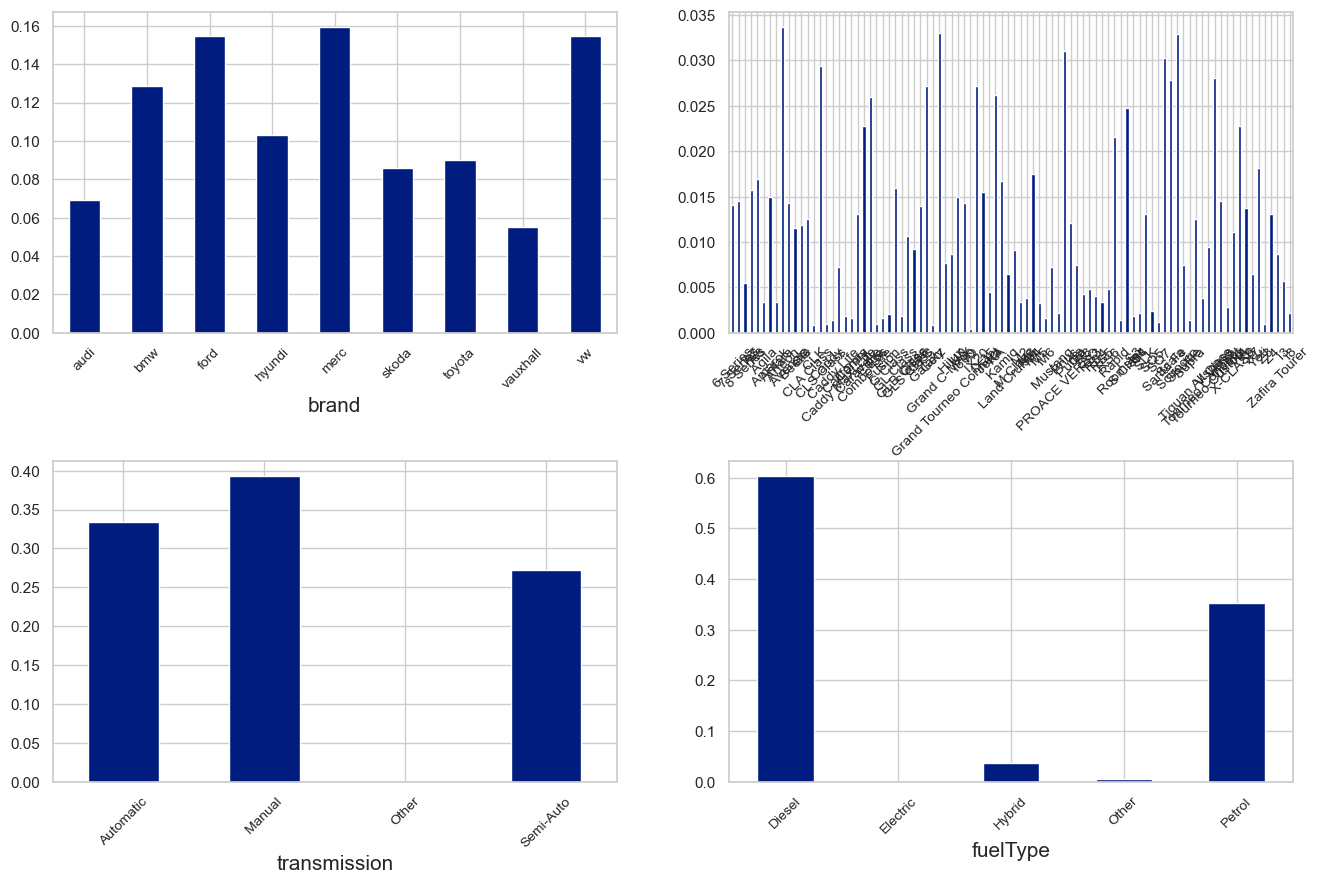

In [7]:
barplot1(df,categorical_features,figsize=(16,10))

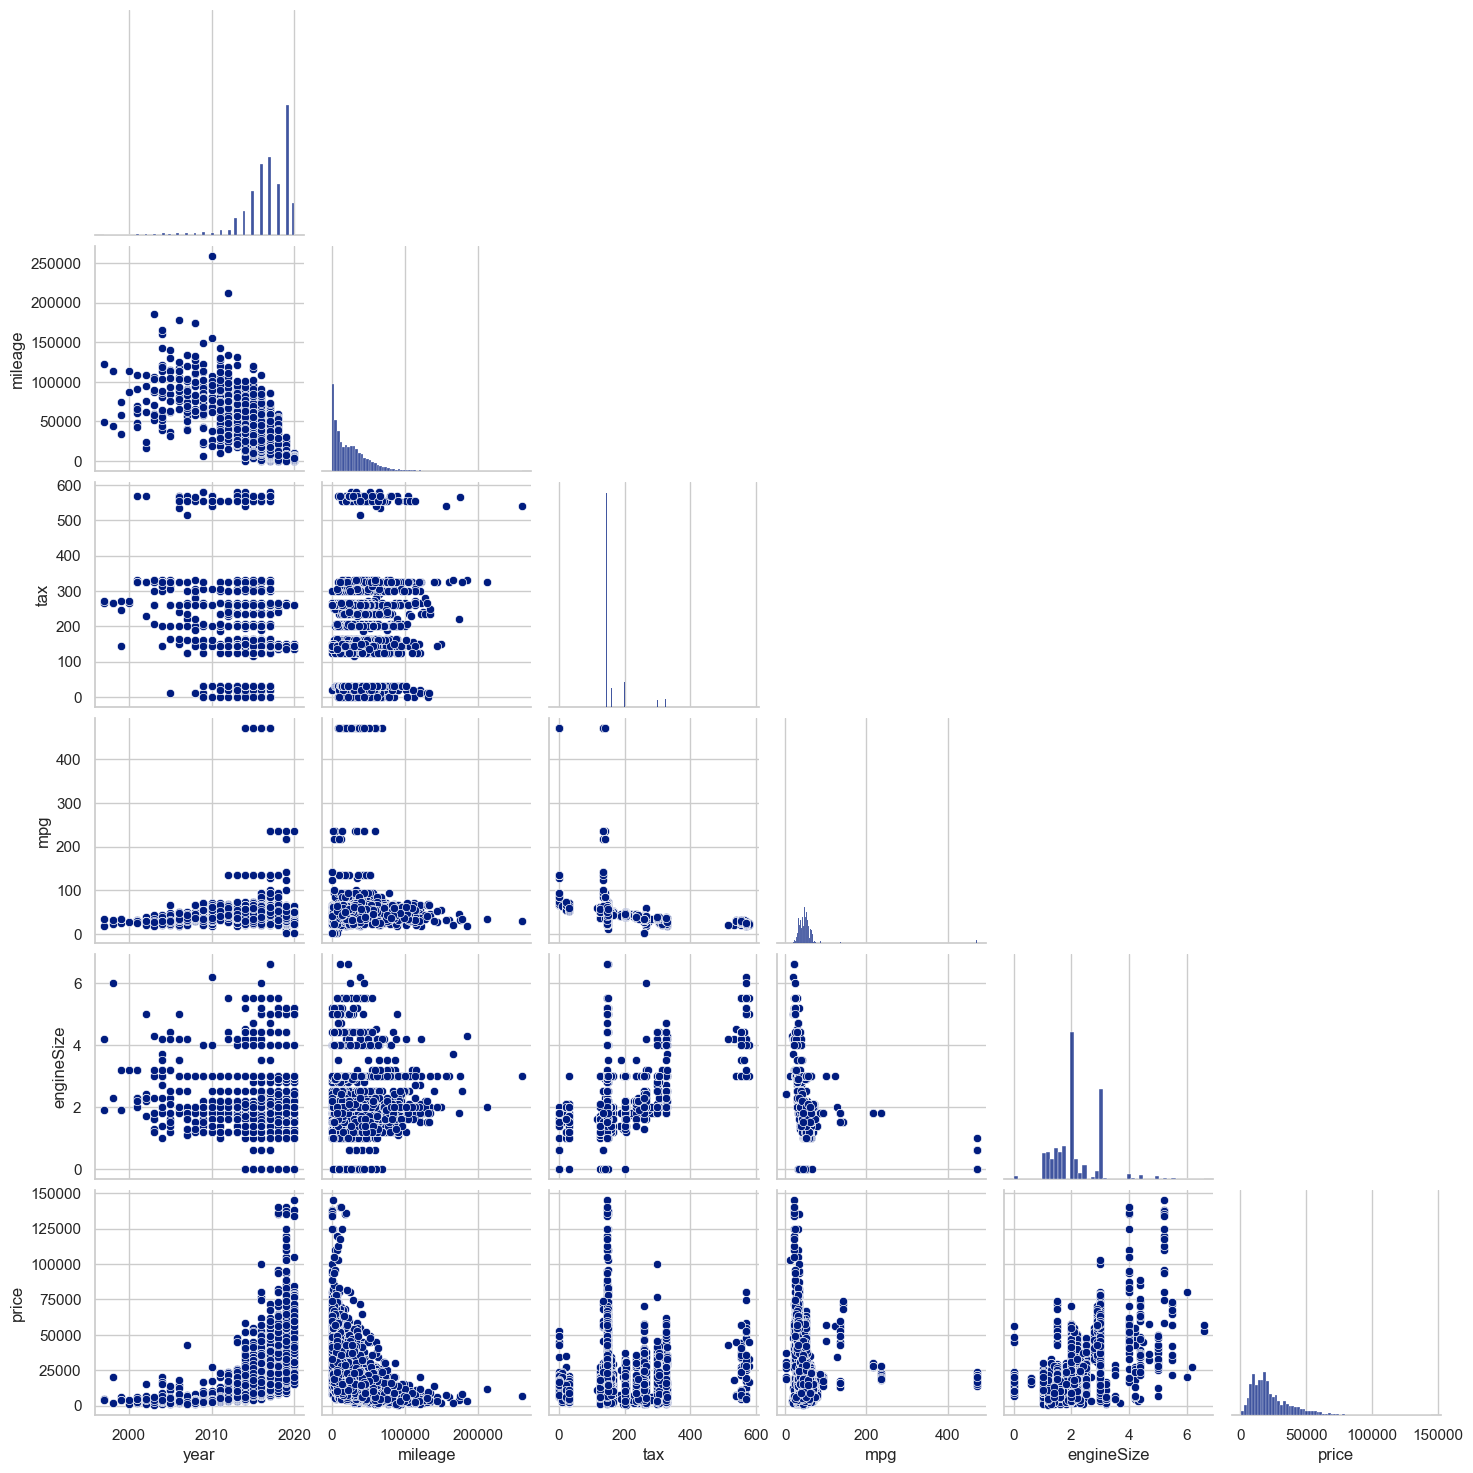

In [8]:
pairplot(df,numeric_features)

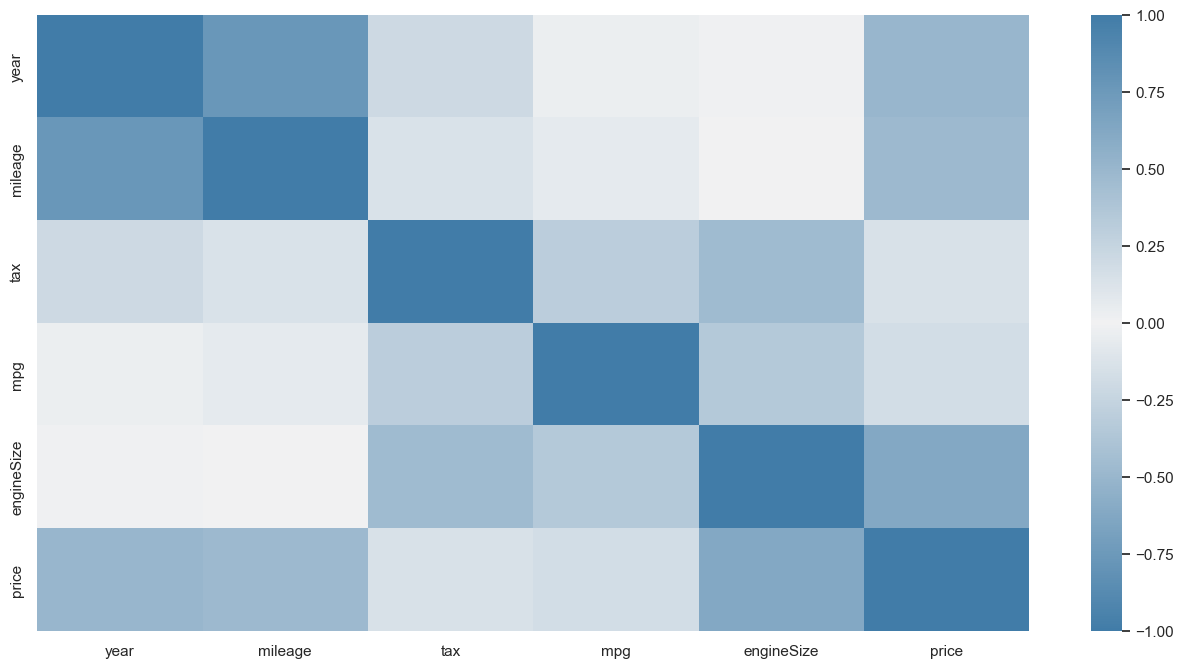

In [9]:
correlogram(df,numeric_features,figsize=(16,8))

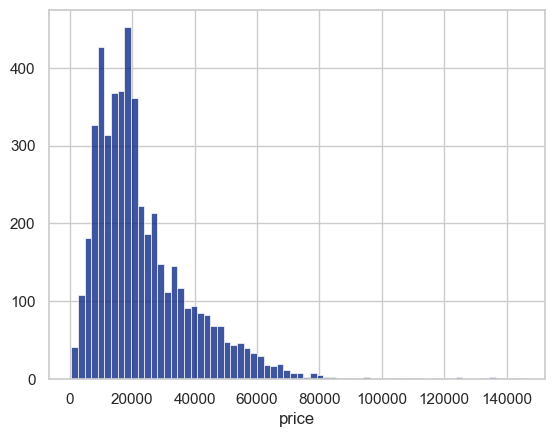

In [9]:
sns.histplot(df,x='price')
plt.ylabel('')
plt.show()

In [10]:
most_freq_models = list(X_train.groupby('model').count().query('year>=100').index)

def model_car_transform(df):
    
    for i in range(df.shape[0]):
        
        model = df['model'].iloc[i]
        
        if most_freq_models.count(model)==0:
            
            df['model'].iloc[i] = 'other'
            
    return df
    

In [11]:
X_train = model_car_transform(X_train)
X_test = model_car_transform(X_test)

In [12]:
X_train = X_train.drop('carID',axis=1)
X_train.insert(0,'years',X_train['year'].max()-X_train['year'])

X_test = X_test.drop('carID',axis=1)
X_test.insert(0,'years',X_train['year'].max()-X_test['year'])

In [13]:
X_train = X_train.drop('year',axis=1)
X_test = X_test.drop('year',axis=1)

In [14]:
numeric_features = X_train.columns[X_train.dtypes!='object']

In [15]:
num_scaler = RobustScaler()
cat_encoder = OneHotEncoder(drop='first',sparse=False)

features_transformer = ColumnTransformer([
    ('numeric',num_scaler,numeric_features),
    ('categorical',cat_encoder,categorical_features)
])

In [16]:
features_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric', RobustScaler(),
                                 Index(['years', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')),
                                ('categorical',
                                 OneHotEncoder(drop='first', sparse=False),
                                 Index(['brand', 'model', 'transmission', 'fuelType'], dtype='object'))])

In [17]:
X_train_t = features_transformer.transform(X_train)
X_test_t = features_transformer.transform(X_test)

In [18]:
pca = PCA()

In [19]:
pca.fit(X_train_t)

PCA()

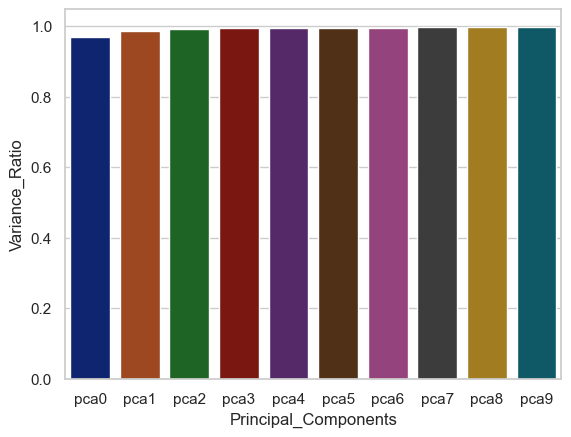

In [20]:
variance_ratio_cum = pd.DataFrame({'Variance_Ratio':pca.explained_variance_ratio_.cumsum(),
                                  'Principal_Components':pca.get_feature_names_out()})

sns.barplot(data=variance_ratio_cum.iloc[:10,:],y='Variance_Ratio',x='Principal_Components')
plt.show()

In [21]:
X_train_pca = pca.transform(X_train_t)[:,:10]
X_test_pca = pca.transform(X_test_t)[:,:10]

y_train_log= np.log(y_train.price.values.reshape(-1,1))
y_test_log= np.log(y_test.price.values.reshape(-1,1))

In [22]:
def linear_model(lr=0.05,activation='relu'):
    
    input_shape = X_train_pca.shape[1]
    
    n_outputs = 1
    
    optimizer = kr.optimizers.SGD(lr)
    
    loss = kr.losses.MeanSquaredError()
    
    
    model = single_layer_perceptron(input_shape,n_outputs,optimizer,loss,activation=activation)
    
    return model


In [23]:
set_random_seed(1)
model = linear_model(lr=0.001,activation='linear')
history = model.fit(X_train_pca,y_train_log,epochs=100,validation_data=(X_test_pca,y_test_log))

Epoch 1/100
155/155 [==============================] - 2s 2ms/step - loss: 75.9126 - val_loss: 54.7119
Epoch 2/100
155/155 [==============================] - 0s 2ms/step - loss: 40.2846 - val_loss: 29.0678
Epoch 3/100
155/155 [==============================] - 0s 2ms/step - loss: 21.7497 - val_loss: 16.1152
Epoch 4/100
155/155 [==============================] - 0s 2ms/step - loss: 11.8985 - val_loss: 8.5563
Epoch 5/100
155/155 [==============================] - 0s 2ms/step - loss: 6.4853 - val_loss: 4.9449
Epoch 6/100
155/155 [==============================] - 0s 2ms/step - loss: 3.5974 - val_loss: 2.6867
Epoch 7/100
155/155 [==============================] - 0s 2ms/step - loss: 2.0224 - val_loss: 1.5371
Epoch 8/100
155/155 [==============================] - 0s 2ms/step - loss: 1.1800 - val_loss: 0.9135
Epoch 9/100
155/155 [==============================] - 0s 2ms/step - loss: 0.7194 - val_loss: 0.5733
Epoch 10/100
155/155 [==============================] - 0s 2ms/step - loss: 0.4567 -

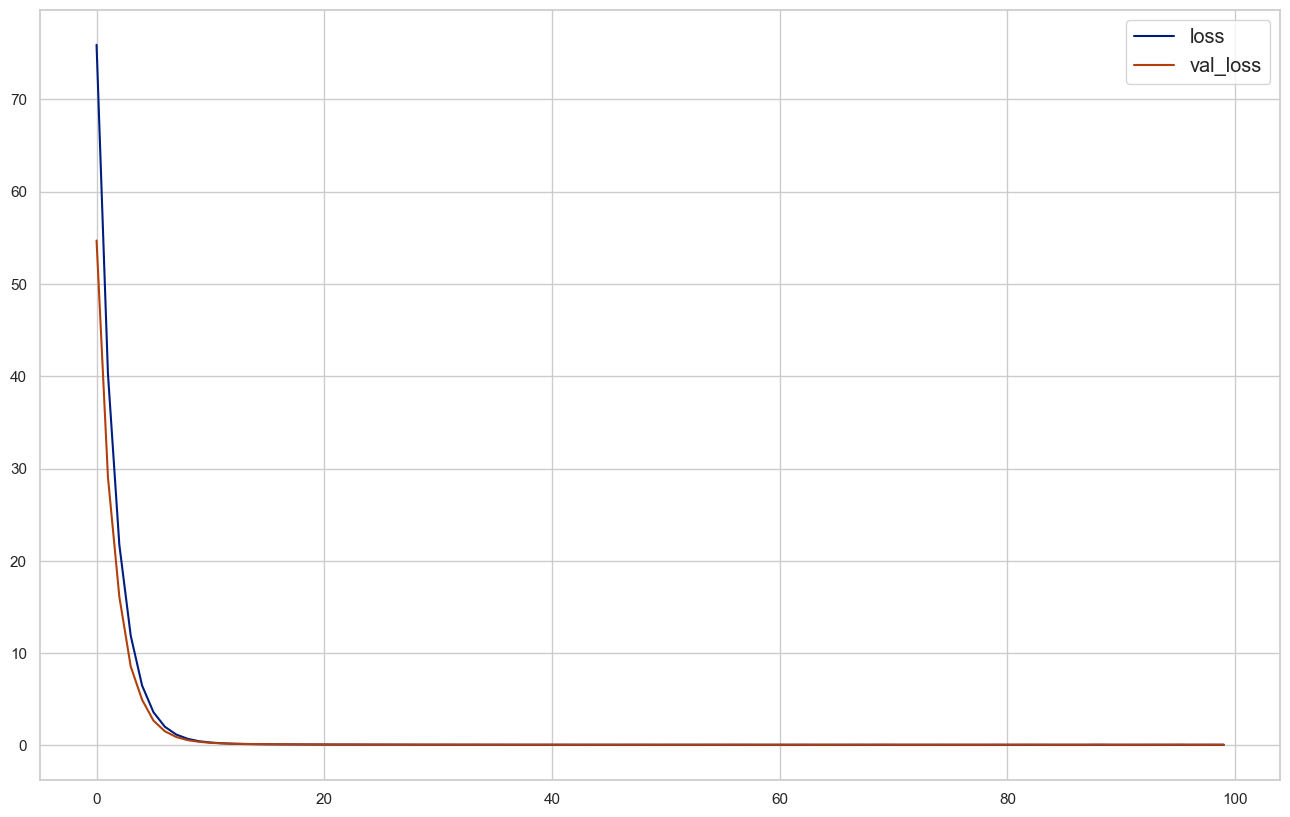

In [24]:
pd.DataFrame(history.history).plot(figsize=(16,10))
plt.legend(fontsize='large')
plt.show()

In [25]:
model.save('used_car_price_model.h5')

In [26]:
pickle.dump(most_freq_models, open('most_freq_models', 'wb'))

In [27]:
pickle.dump([features_transformer,pca], open('preprocessing_data', 'wb'))

In [28]:
X_train.brand.unique()

array(['hyundi', 'vauxhall', 'audi', 'vw', 'skoda', 'merc', 'toyota',
       'bmw', 'ford'], dtype=object)

In [30]:
features_transformer.feature_names_in_

array(['years', 'brand', 'model', 'transmission', 'mileage', 'fuelType',
       'tax', 'mpg', 'engineSize'], dtype=object)

In [33]:
X_train.iloc[0,:].values

array([1, 'hyundi', ' Santa Fe', 'Semi-Auto', 4223, 'Diesel', 145.0, 39.8,
       2.2], dtype=object)

In [41]:
pd.DataFrame(X_train.iloc[1:2,:].values,columns=X_train.columns)

years     brand  model transmission mileage fuelType    tax   mpg engineSize
0     5  vauxhall  other       Manual   47870   Diesel  125.0  60.1        2.0

In [36]:
X_train.iloc[0,:]

years                   1
brand              hyundi
model            Santa Fe
transmission    Semi-Auto
mileage              4223
fuelType           Diesel
tax                 145.0
mpg                  39.8
engineSize            2.2
Name: 0, dtype: object